### Question Answering on unstructured text by building Knowledge graph using langchain and openai
This notebook shows how to use langchain with openai to build a knowledge graph from unstructured text.
Using Openai, first knowledge triples are extracted (if knowledge triples are already known, they can be directly inserted to graph).
Then we use the langchain for question answering on the knowledge graph using openai.

In [1]:
!pip install openai langchain networkx matplotlib

##### Install pydantic 1.0 version as 2.0 version gives errors with langchain

In [2]:
!pip install pydantic==1.10.9

##### Check langchain version, this was tested with '0.0.321'

In [1]:
import langchain
langchain.__version__

'0.0.321'

In [2]:
import networkx
networkx.__version__

'2.8.4'

In [3]:
from langchain.llms import OpenAI

In [4]:
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain

In [5]:
import openai, os

OPENAI_API_KEY Environment variable must be set with the api key for openai before running next cell.

It can also be set within code by using below line in code cell and replacing "key" with actual key.

os.environ["OPENAI_API_KEY"] = "key"

In [6]:
openai.api_key = os.environ["OPENAI_API_KEY"]

In [7]:
index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))

In [8]:
with open("state_of_the_union.txt", encoding="UTF-8") as f:
    all_text = f.read()

In [9]:
text = "\n".join(all_text.split("\n\n")[105:108])
text

'It won’t look like much, but if you stop and look closely, you’ll see a “Field of dreams,” the ground on which America’s future will be built. \nThis is where Intel, the American company that helped build Silicon Valley, is going to build its $20 billion semiconductor “mega site”. \nUp to eight state-of-the-art factories in one place. 10,000 new good-paying jobs. '

In [10]:
graph = index_creator.from_text(text)

In [11]:
type(graph)

langchain.graphs.networkx_graph.NetworkxEntityGraph

In [12]:
graph.get_triples() 

[('Intel', '$20 billion semiconductor "mega site"', 'is going to build'),
 ('Intel', 'state-of-the-art factories', 'is building'),
 ('Intel', '10,000 new good-paying jobs', 'is creating'),
 ('Intel', 'Silicon Valley', 'is helping build'),
 ('Field of dreams',
  "America's future will be built",
  'is the ground on which')]

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, target, relation in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

To add custom triples (custom nodes and edges) to existing graph in case if triples are already known, below cell commands can be used -

In [14]:
from langchain.graphs.networkx_graph import KnowledgeTriple
graph.add_triple(KnowledgeTriple('Google', 'invests', '$300 Million'))
graph.add_triple(KnowledgeTriple('Google', 'invests in', 'Anthropic'))

In [18]:
# Triples after manually adding nodes and edges
graph.get_triples()

[('Intel', '$20 billion semiconductor "mega site"', 'is going to build'),
 ('Intel', 'state-of-the-art factories', 'is building'),
 ('Intel', '10,000 new good-paying jobs', 'is creating'),
 ('Intel', 'Silicon Valley', 'is helping build'),
 ('Field of dreams',
  "America's future will be built",
  'is the ground on which'),
 ('Google', '$300 Million', 'invests'),
 ('Google', 'Anthropic', 'invests in')]

In [15]:
# Question Answering
question = 'what is Intel going to build?'
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Intel
Full Context:
Intel is going to build $20 billion semiconductor "mega site"
Intel is building state-of-the-art factories
Intel is creating 10,000 new good-paying jobs
Intel is helping build Silicon Valley

> Finished chain.


' Intel is going to build a $20 billion semiconductor "mega site" with state-of-the-art factories, creating 10,000 new good-paying jobs and helping to build Silicon Valley.'

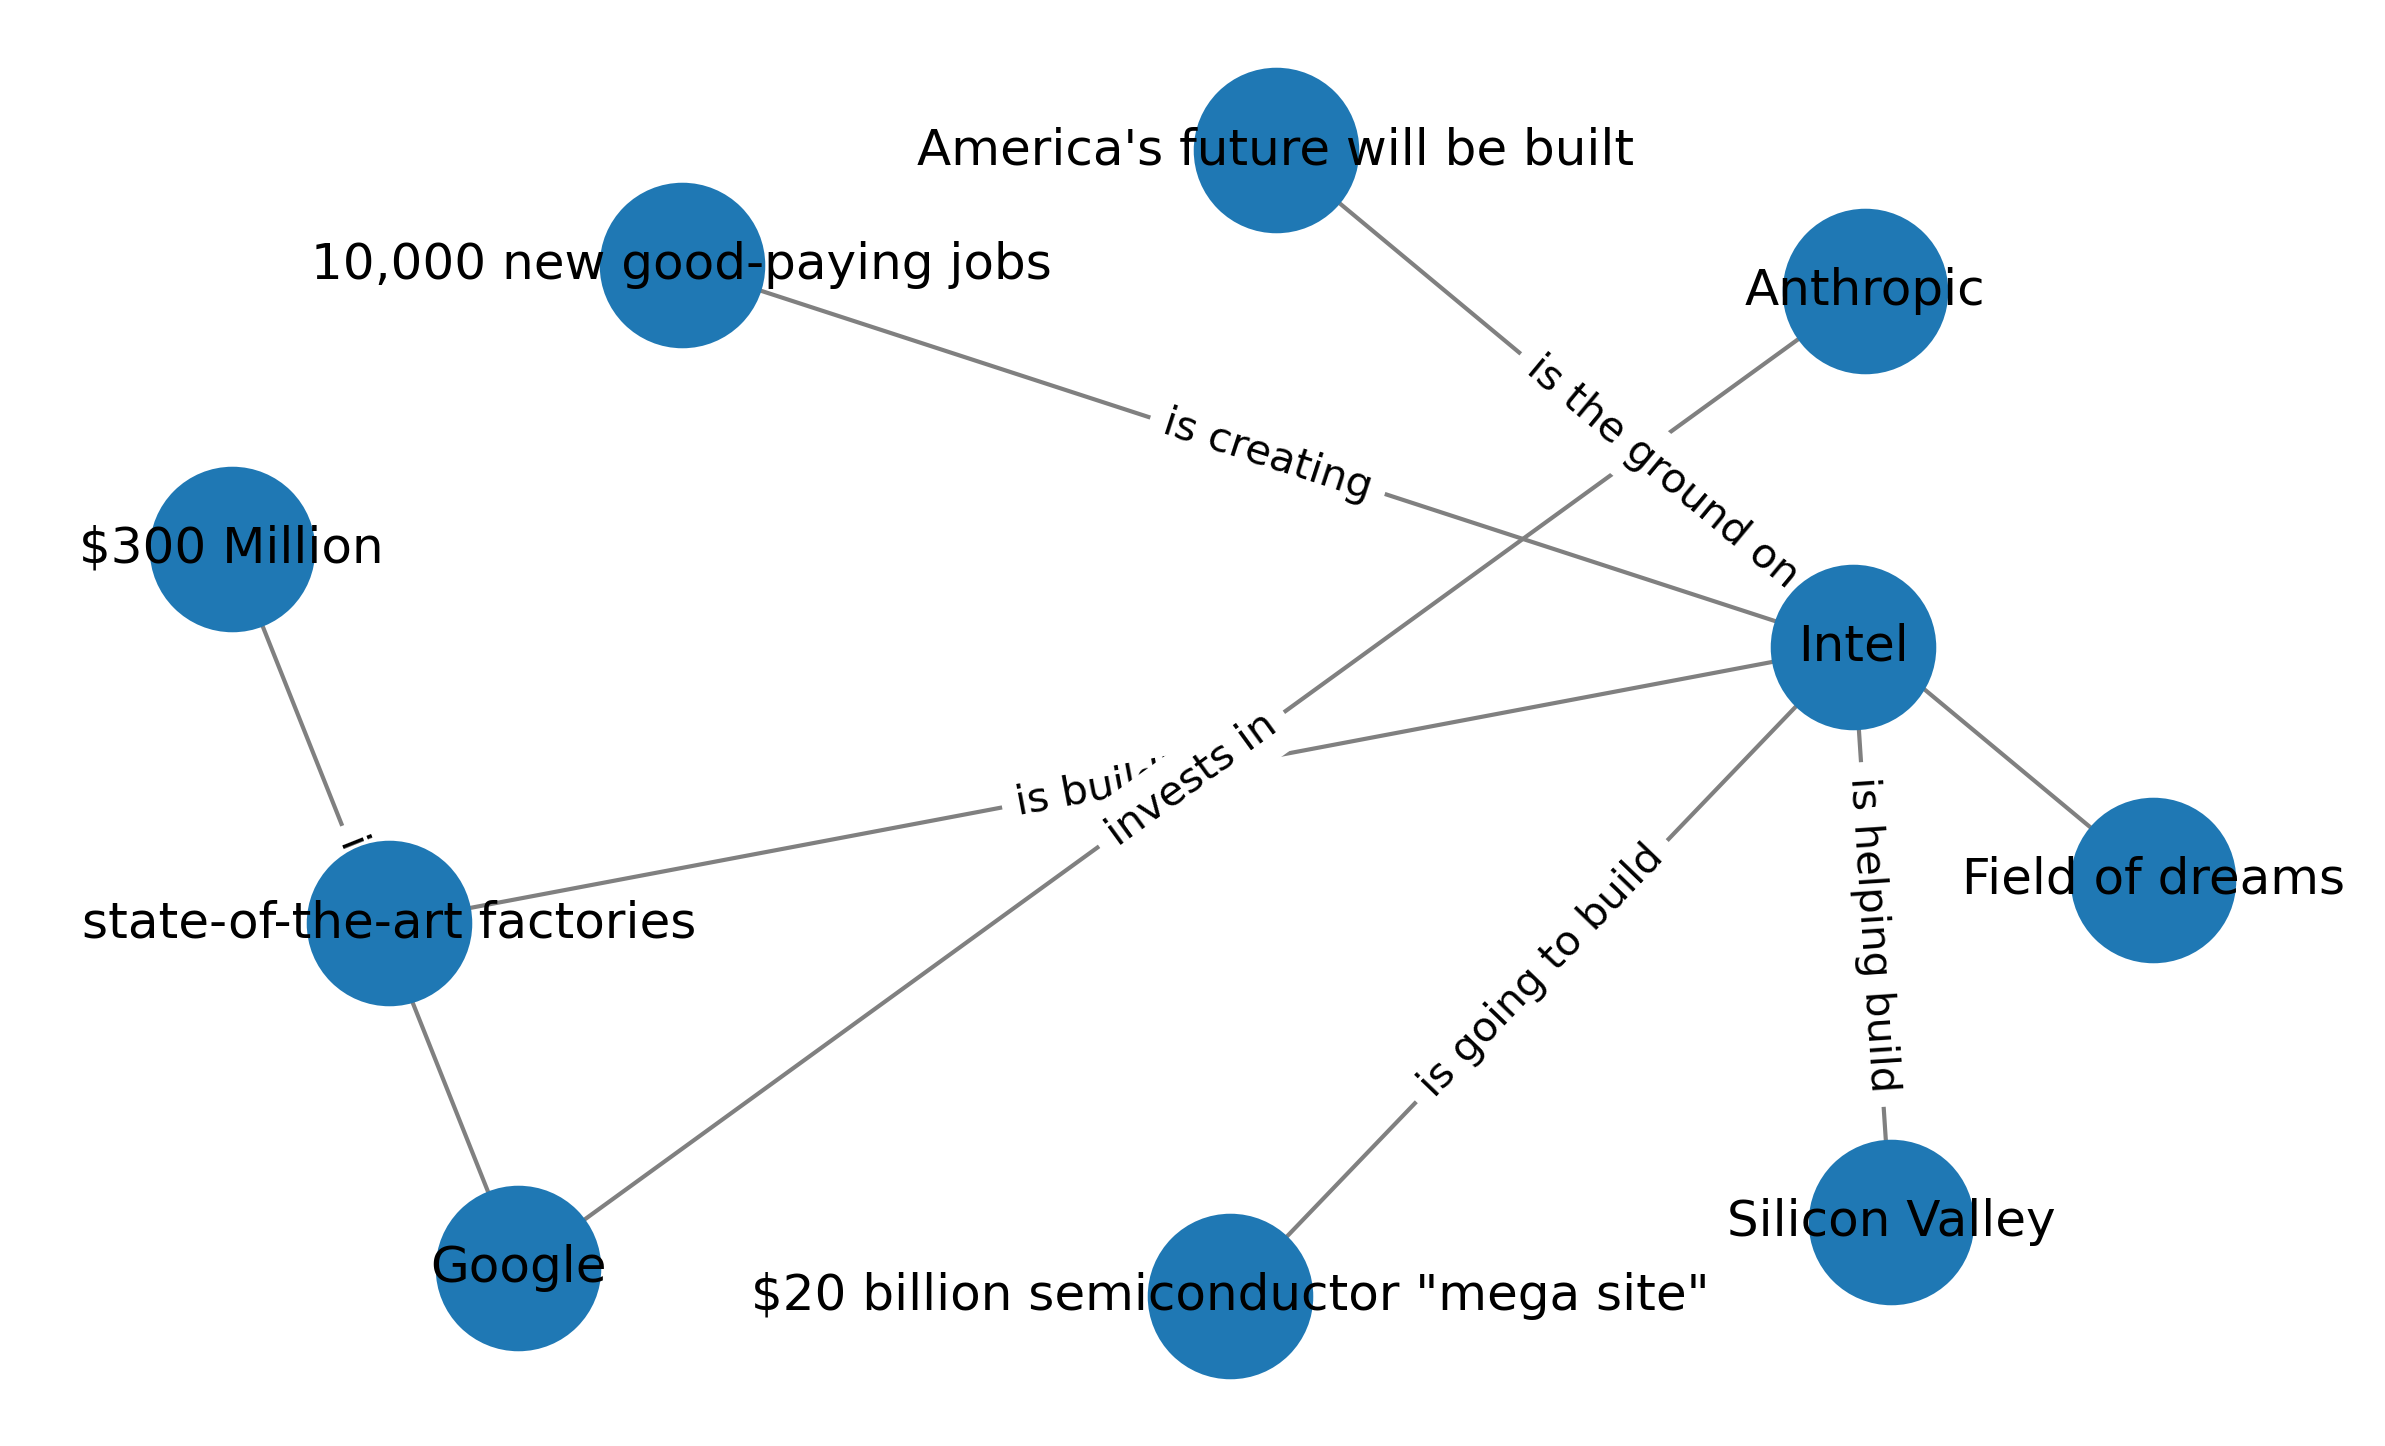

In [16]:
# Plotting the graph
plot_graph(graph.get_triples())